In [94]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [95]:
!pwd

/home/timjab92/code/timjab92/cryptotrading-indicator/notebooks


In [96]:
model = load_model("../good_model/RNN_best/new_data_high_bollinger_up_rsi_1_73")

In [97]:
import requests
def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api


def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data[CLOSE])
    add_vol_roc(data)
    return data

## add other features

def add_ema(data, tspan=[12,26,20,50,34,55,21,99,200]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data[CLOSE].ewm(span=t).mean()
        data[f'dist_ema{t}'] = data[CLOSE] - data[f'ema{t}']
    return data


def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi


def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  


def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data[CLOSE], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data


def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down


def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    for i in ['bollinger_up', 'bollinger_down']:
        data[f'dist_{i}'] = data[CLOSE] - data[i]
    return data


def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data


In [98]:
def get_train_data():
    """
    Returns the raw training dataset for the price of bitcoin since 31.12.2011.
    The index is set to the date.
    """
    data = pd.read_csv("../data/BTCUSD_4hours.csv")
    data['date'] = pd.to_datetime(data.date)
    data_train = data.drop(columns="Unnamed: 0").set_index("date")
    return data_train


def minmaxscaling(data_train):
    """
    applies the minmaxscaler to the training set. Attention! Output needs to be
    defined for data_train_scaled, min1 and range1!!
    """
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    minmax_scaler.fit(data_train)
    data_train_scaled = minmax_scaler.transform(data_train)
    min1 = minmax_scaler.data_min_  # [5:9] for log_prices
    range1 = minmax_scaler.data_range_  #[5:9]
    return data_train_scaled, minmax_scaler, min1, range1


def get_xgecko(winsize=18, horizon=1):
    """
    Calls the coingecko API and returns the data used for prediction.
    x_gecko.shape == (no_sequ , winsize, no_features)
    """
    x_gecko = feature_engineer(get_coingecko())[SELECTED_FEATURES][-winsize:]
    #get scaler the long way
    data_train = feature_engineer(get_train_data())[SELECTED_FEATURES]
    data_train_scaled, scaler,min1,range1 = minmaxscaling(data_train)

    x_gecko_scaled = scaler.transform(x_gecko)
    x_gecko = np.array(x_gecko_scaled[-winsize:])
    x_gecko = np.reshape(x_gecko, (-1, winsize, len(SELECTED_FEATURES)))
    return x_gecko

In [120]:
CLOSE = 'close'
SELECTED_FEATURES = [CLOSE,'high','bollinger_up','rsi']

In [121]:
x_gecko = get_xgecko()

In [122]:
x_gecko.shape

(1, 18, 4)

In [123]:
data_train_scaled, scaler, min1, range1 = minmaxscaling(feature_engineer(get_train_data())[[CLOSE]])

In [124]:
pred = model.predict(x_gecko)

In [125]:
pred

array([[0.64001757]], dtype=float32)

In [126]:
#pred = np.exp(scaler.inverse_transform(pred))

In [127]:
pred = scaler.inverse_transform(pred)

In [128]:
pred[0][0]

41179.305

In [129]:
pred

array([[41179.305]], dtype=float32)

In [ ]:
df = coingecko[[CLOSE]].reset_index(drop=True) #.apply(lambda x: np.exp(x))

In [ ]:
#df1 = pd.DataFrame(pred_gecko_unscaled.reshape(4,1),columns=[CLOSE]).apply(lambda x: np.exp(x))

In [ ]:
df2 = pd.concat([df,df1],axis=0).reset_index(drop=True)
df2

# Whats going on?!?

In [14]:
data = feature_engineer(get_train_data())
data.dropna(inplace=True)
data = data.iloc[1: , :]

In [15]:
data.drop(columns=['open','high','low','close'], inplace = True)

In [16]:
data

,volume,log_open,log_high,log_low,log_close,ema12,dist_ema12,ema26,dist_ema26,ema20,...,dist_ema200,rsi,K,D,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc
date,,,,,,,,,,,,,,,,,,,,,
2012-01-11 08:00:00,1.858932,1.949820,1.949820,1.949820,1.949820,1.898467,0.051354,1.859967,0.089854,1.874226,...,0.154492,65.970885,37.306777,24.696599,1.890427,1.981574,1.799280,-0.031753,0.150541,-0.595712
2012-01-11 12:00:00,1.895918,1.974294,1.974876,1.974294,1.974876,1.910262,0.064614,1.869149,0.105727,1.884142,...,0.173350,68.023084,51.197785,37.636130,1.898878,1.988336,1.809419,-0.013460,0.165457,0.019896
2012-01-11 16:00:00,2.987143,1.938716,1.938716,1.938716,1.938716,1.914652,0.024063,1.874676,0.064040,1.889500,...,0.132567,62.193690,50.078456,46.194339,1.902687,1.992116,1.813258,-0.053400,0.125458,0.575566
2012-01-11 20:00:00,8.315000,1.945910,1.945910,1.945910,1.945910,1.919473,0.026437,1.880305,0.065605,1.895023,...,0.135161,62.875361,44.821949,48.699397,1.906934,1.996089,1.817779,-0.050179,0.128131,1.783596
2012-01-12 04:00:00,8.800000,1.938742,1.938742,1.938742,1.938742,1.922444,0.016298,1.884900,0.053841,1.899292,...,0.123875,61.681954,33.031877,42.644094,1.909735,1.999206,1.820264,-0.060465,0.118477,0.058328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,1.697971,10.794844,10.795222,10.794435,10.794853,10.792529,0.002323,10.775250,0.019603,10.781677,...,0.143479,62.080327,36.210154,50.235845,10.777789,10.840219,10.715358,-0.045367,0.079495,2.306553
2021-08-22 16:00:00,0.463362,10.791204,10.791498,10.790859,10.791202,10.792325,-0.001123,10.776432,0.014771,10.782584,...,0.138438,59.525060,19.004941,36.146357,10.782060,10.834660,10.729461,-0.043457,0.061742,-0.727108
2021-08-22 20:00:00,0.605696,10.795610,10.795982,10.795279,10.795660,10.792838,0.002822,10.777856,0.017804,10.783830,...,0.141474,61.603611,5.196078,20.137058,10.786118,10.828258,10.743977,-0.032598,0.051684,0.307177


In [76]:
data['boll_width'] = data['bollinger_up'] - data['bollinger_down']

In [77]:
data

,volume,log_open,log_high,log_low,log_close,ema12,dist_ema12,ema26,dist_ema26,ema20,...,rsi,K,D,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,boll_width
date,,,,,,,,,,,,,,,,,,,,,
2012-01-11 08:00:00,1.858932,1.949820,1.949820,1.949820,1.949820,1.898467,0.051354,1.859967,0.089854,1.874226,...,65.970885,37.306777,24.696599,1.890427,1.981574,1.799280,-0.031753,0.150541,-0.595712,0.182294
2012-01-11 12:00:00,1.895918,1.974294,1.974876,1.974294,1.974876,1.910262,0.064614,1.869149,0.105727,1.884142,...,68.023084,51.197785,37.636130,1.898878,1.988336,1.809419,-0.013460,0.165457,0.019896,0.178916
2012-01-11 16:00:00,2.987143,1.938716,1.938716,1.938716,1.938716,1.914652,0.024063,1.874676,0.064040,1.889500,...,62.193690,50.078456,46.194339,1.902687,1.992116,1.813258,-0.053400,0.125458,0.575566,0.178858
2012-01-11 20:00:00,8.315000,1.945910,1.945910,1.945910,1.945910,1.919473,0.026437,1.880305,0.065605,1.895023,...,62.875361,44.821949,48.699397,1.906934,1.996089,1.817779,-0.050179,0.128131,1.783596,0.178310
2012-01-12 04:00:00,8.800000,1.938742,1.938742,1.938742,1.938742,1.922444,0.016298,1.884900,0.053841,1.899292,...,61.681954,33.031877,42.644094,1.909735,1.999206,1.820264,-0.060465,0.118477,0.058328,0.178942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,1.697971,10.794844,10.795222,10.794435,10.794853,10.792529,0.002323,10.775250,0.019603,10.781677,...,62.080327,36.210154,50.235845,10.777789,10.840219,10.715358,-0.045367,0.079495,2.306553,0.124861
2021-08-22 16:00:00,0.463362,10.791204,10.791498,10.790859,10.791202,10.792325,-0.001123,10.776432,0.014771,10.782584,...,59.525060,19.004941,36.146357,10.782060,10.834660,10.729461,-0.043457,0.061742,-0.727108,0.105199
2021-08-22 20:00:00,0.605696,10.795610,10.795982,10.795279,10.795660,10.792838,0.002822,10.777856,0.017804,10.783830,...,61.603611,5.196078,20.137058,10.786118,10.828258,10.743977,-0.032598,0.051684,0.307177,0.084281


In [59]:
import seaborn as sns

In [60]:
df1 = data[['log_close', 'vol_roc', 'ema12','ema26','ema20','ema50','ema34','ema55', 'bollinger_up','bollinger_down']].corr()

<AxesSubplot:>

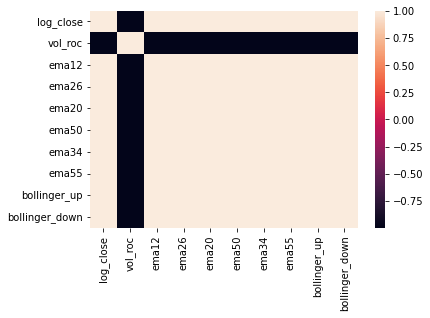

In [61]:
sns.heatmap(df1.corr())

In [62]:
data.keys()

Index(['volume', 'log_open', 'log_high', 'log_low', 'log_close', 'ema12',
       'dist_ema12', 'ema26', 'dist_ema26', 'ema20', 'dist_ema20', 'ema50',
       'dist_ema50', 'ema34', 'dist_ema34', 'ema55', 'dist_ema55', 'ema21',
       'dist_ema21', 'ema99', 'dist_ema99', 'ema200', 'dist_ema200', 'rsi',
       'K', 'D', 'sma', 'bollinger_up', 'bollinger_down', 'dist_bollinger_up',
       'dist_bollinger_down', 'vol_roc'],
      dtype='object')

In [63]:
df2 = data[['log_close','vol_roc',
       'dist_ema12', 'dist_ema26', 'dist_ema20',
       'dist_ema50', 'dist_ema34', 'dist_ema55', 'dist_bollinger_up',
       'dist_bollinger_down']]

<AxesSubplot:>

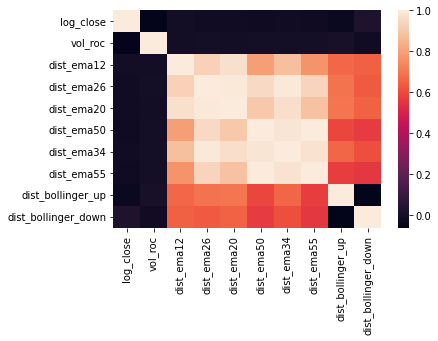

In [64]:
sns.heatmap(df2.corr())

In [68]:
data.keys()

Index(['volume', 'log_open', 'log_high', 'log_low', 'log_close', 'ema12',
       'dist_ema12', 'ema26', 'dist_ema26', 'ema20', 'dist_ema20', 'ema50',
       'dist_ema50', 'ema34', 'dist_ema34', 'ema55', 'dist_ema55', 'ema21',
       'dist_ema21', 'ema99', 'dist_ema99', 'ema200', 'dist_ema200', 'rsi',
       'K', 'D', 'sma', 'bollinger_up', 'bollinger_down', 'dist_bollinger_up',
       'dist_bollinger_down', 'vol_roc'],
      dtype='object')

<AxesSubplot:>

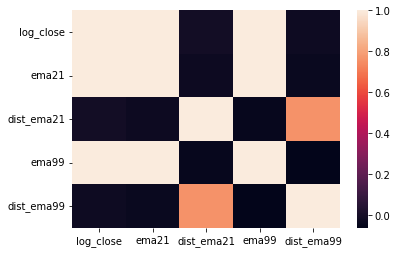

In [71]:
sns.heatmap(data[['log_close', 'ema21', 'dist_ema21', 'ema99', 'dist_ema99']].corr())

In [67]:
df = pd.DataFrame(data[['log_close','vol_roc']])

In [ ]:
# for i in [12, 26, 20, 50, 34, 55]:
#     df[f'dist_ema{i}'] = data['log_close'] - data[f'ema{i}']

In [ ]:
# for i in ['bollinger_up', 'bollinger_down']:
#     df[f'dist_{i}'] = data['log_close'] - data[i]

In [ ]:
df.corr()

In [6]:
def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data.log_close)
    add_vol_roc(data)
    return data

In [7]:
df.keys()

NameError: name 'df' is not defined

In [64]:
data[['log_close', 'vol_roc', 'ema12','ema26','ema20','ema50','ema34','ema55', 'bollinger_up','bollinger_down']].corr()

,log_close,vol_roc,ema12,ema26,ema20,ema50,ema34,ema55,bollinger_up,bollinger_down
log_close,1.000000,-0.053434,0.999922,0.999814,0.999861,0.999619,0.999750,0.999576,0.999562,0.999617
vol_roc,-0.053434,1.000000,-0.053340,-0.053300,-0.053316,-0.053251,-0.053281,-0.053243,-0.053555,-0.053063
ema12,0.999922,-0.053340,1.000000,0.999960,0.999984,0.999813,0.999917,0.999777,0.999729,0.999762
ema26,0.999814,-0.053300,0.999960,1.000000,0.999994,0.999938,0.999992,0.999915,0.999768,0.999769
ema20,0.999861,-0.053316,0.999984,0.999994,1.000000,0.999896,0.999971,0.999867,0.999767,0.999778
ema50,0.999619,-0.053251,0.999813,0.999938,0.999896,1.000000,0.999975,0.999998,0.999666,0.999670
ema34,0.999750,-0.053281,0.999917,0.999992,0.999971,0.999975,1.000000,0.999959,0.999749,0.999744
ema55,0.999576,-0.053243,0.999777,0.999915,0.999867,0.999998,0.999959,1.000000,0.999632,0.999643
bollinger_up,0.999562,-0.053555,0.999729,0.999768,0.999767,0.999666,0.999749,0.999632,1.000000,0.999130
bollinger_down,0.999617,-0.053063,0.999762,0.999769,0.999778,0.999670,0.999744,0.999643,0.999130,1.000000


# redefining get_xy

In [56]:
LENGTH = 60
HORIZON = 1
SELECTED_FEATURES=['log_price']

In [57]:
def get_xy(data_train_scaled, length=LENGTH, horizon=HORIZON):
    y_train = []
    x_train = [
        data_train_scaled[i - length:i, 0] for i in range(length, len(data_train_scaled))
        ]
    y_train = [
        data_train_scaled[i, 0] for i in range(length, len(data_train_scaled))
    ]

    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(SELECTED_FEATURES)))
    return x_train, y_train

In [58]:
data_train_scaled, scaler = minmaxscaling(feature_engineer(get_train_data())[['log_close']])

In [67]:
x1,y1= get_xy(data_train_scaled, 60,1)

In [61]:
x.shape

(20780, 60, 1)

In [62]:
y.shape

(20780,)

In [63]:
y

array([0.0375906 , 0.04078993, 0.05089851, ..., 0.9713156 , 0.97336611,
       0.97439441])

In [68]:
def get_xy_alt(data_train_scaled, window_size=60, horizon=1):
    data_train_subsequences = []
    fake_y_train = []
    for k in range(len(data_train_scaled)-(window_size-1)-horizon):
        data_train_subsequences.append(data_train_scaled[k:k+window_size])
        fake_y_train.append(data_train_scaled[k+window_size]) #add [0] for log_price to be predicted
    
    X_train = np.array(data_train_subsequences)
    y_train = np.array(fake_y_train)[:,0].reshape(-1,1)
    return X_train, y_train

In [66]:
x2,y2 = get_xy_alt(data_train_scaled,60,1)

In [77]:
y2.shape

(20780, 1)

In [75]:
y1

array([0.0375906 , 0.04078993, 0.05089851, ..., 0.9713156 , 0.97336611,
       0.97439441])

In [76]:
y2

array([[0.0375906 ],
       [0.04078993],
       [0.05089851],
       ...,
       [0.9713156 ],
       [0.97336611],
       [0.97439441]])

In [99]:
coingecko = feature_engineer(get_coingecko())
coingecko['gradient'] = coingecko['close'].diff()

In [100]:
coingecko.keys()

Index(['open', 'high', 'low', 'close', 'volume', 'log_open', 'log_high',
       'log_low', 'log_close', 'ema12', 'dist_ema12', 'ema26', 'dist_ema26',
       'ema20', 'dist_ema20', 'ema50', 'dist_ema50', 'ema34', 'dist_ema34',
       'ema55', 'dist_ema55', 'ema21', 'dist_ema21', 'ema99', 'dist_ema99',
       'ema200', 'dist_ema200', 'rsi', 'K', 'D', 'sma', 'bollinger_up',
       'bollinger_down', 'dist_bollinger_up', 'dist_bollinger_down', 'vol_roc',
       'gradient'],
      dtype='object')

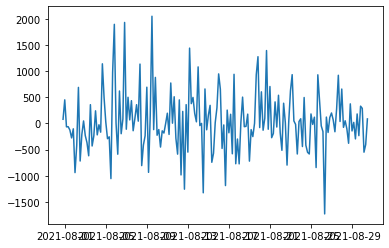

In [102]:
plt.plot(coingecko['gradient'])

In [104]:
coingecko.corr()

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,rsi,K,D,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,gradient
open,1.000000,0.994405,0.996547,0.988271,0.213107,0.999322,0.993594,0.996161,0.987853,0.972712,...,0.423314,-0.072887,-0.041935,0.914817,0.940995,0.857781,0.341788,-0.097604,-0.092708,-0.060664
high,0.994405,1.000000,0.994725,0.996528,0.231864,0.993936,0.999349,0.994483,0.996211,0.970374,...,0.449565,-0.059700,-0.042149,0.911720,0.938561,0.854312,0.378554,-0.074246,-0.065626,0.022714
low,0.996547,0.994725,1.000000,0.994212,0.208095,0.995753,0.993713,0.999318,0.993430,0.973012,...,0.430410,-0.062086,-0.039709,0.916180,0.943936,0.857903,0.353799,-0.087022,-0.103184,-0.008589
close,0.988271,0.996528,0.994212,1.000000,0.229710,0.987713,0.995732,0.993696,0.999345,0.968653,...,0.457235,-0.056228,-0.050502,0.910050,0.936283,0.853167,0.395380,-0.066060,-0.066638,0.074282
volume,0.213107,0.231864,0.208095,0.229710,1.000000,0.228400,0.247754,0.223893,0.245952,0.115246,...,0.609575,0.287843,0.277386,-0.204270,-0.103259,-0.271867,0.363913,0.569564,0.160507,0.145189
log_open,0.999322,0.993936,0.995753,0.987713,0.228400,1.000000,0.994423,0.996706,0.988562,0.971883,...,0.434427,-0.085716,-0.054789,0.912963,0.940240,0.855177,0.346398,-0.091195,-0.096971,-0.058163
log_high,0.993594,0.999349,0.993713,0.995732,0.247754,0.994423,1.000000,0.994768,0.996701,0.969281,...,0.460787,-0.072548,-0.054614,0.909695,0.937389,0.851729,0.383657,-0.068203,-0.068958,0.024767
log_low,0.996161,0.994483,0.999318,0.993696,0.223893,0.996706,0.994768,1.000000,0.994212,0.972437,...,0.440813,-0.075972,-0.053291,0.914805,0.943711,0.855719,0.357021,-0.081416,-0.107258,-0.007411
log_close,0.987853,0.996211,0.993430,0.999345,0.245952,0.988562,0.996701,0.994212,1.000000,0.967921,...,0.467968,-0.069391,-0.063088,0.908467,0.935545,0.851015,0.399638,-0.060680,-0.069693,0.074802
ema12,0.972712,0.970374,0.973012,0.968653,0.115246,0.971883,0.969281,0.972437,0.967921,1.000000,...,0.240901,-0.313249,-0.288095,0.982521,0.982416,0.942480,0.172861,-0.292417,-0.099489,-0.062247


In [82]:
import matplotlib.pyplot as plt

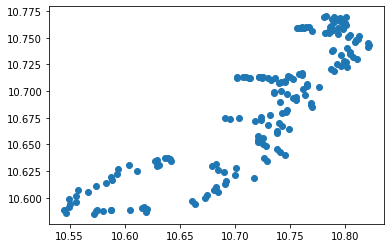

In [114]:
plt.scatter(coingecko['log_close'], coingecko['ema99'])